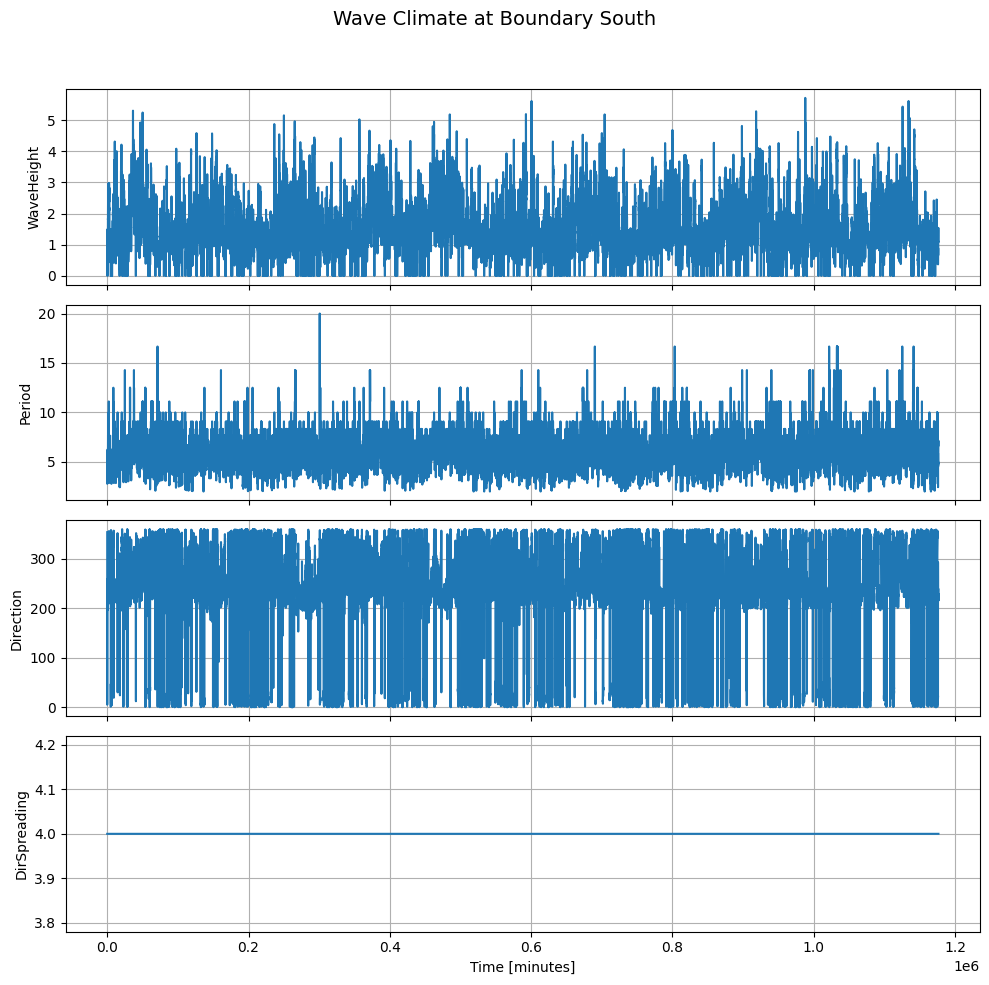

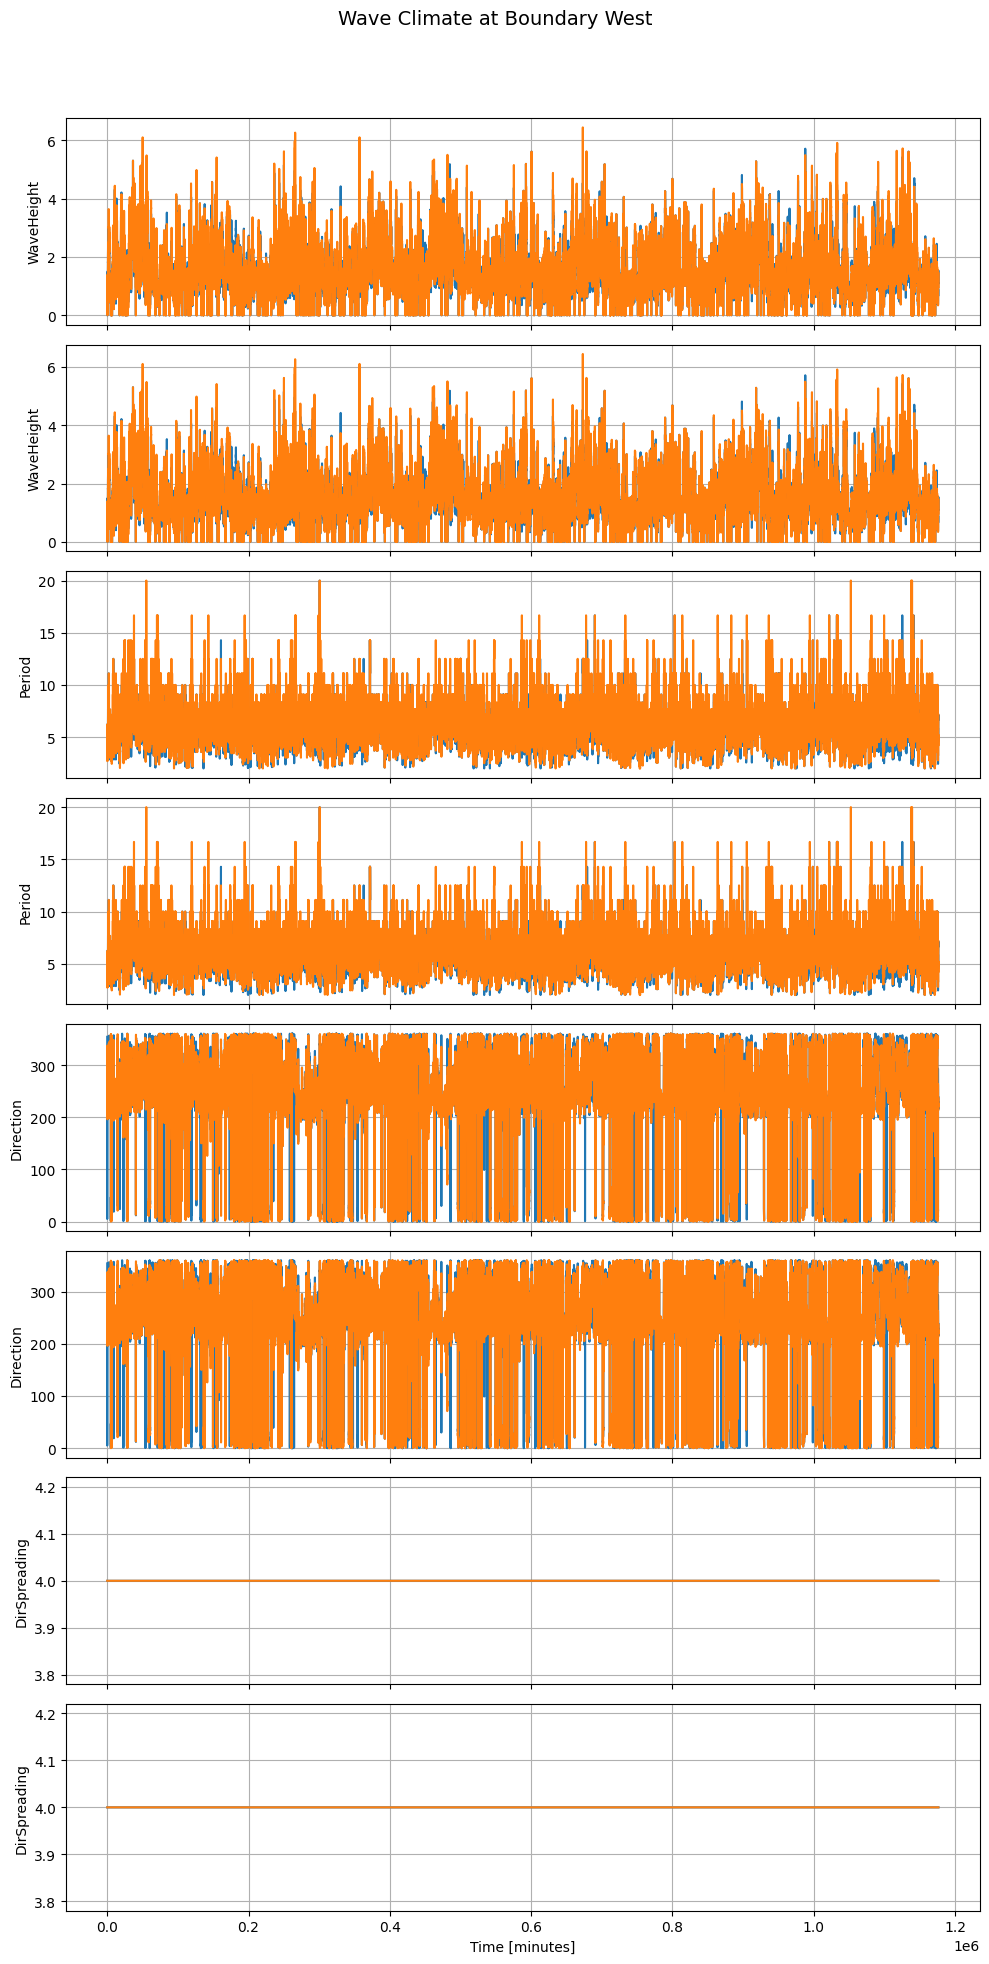

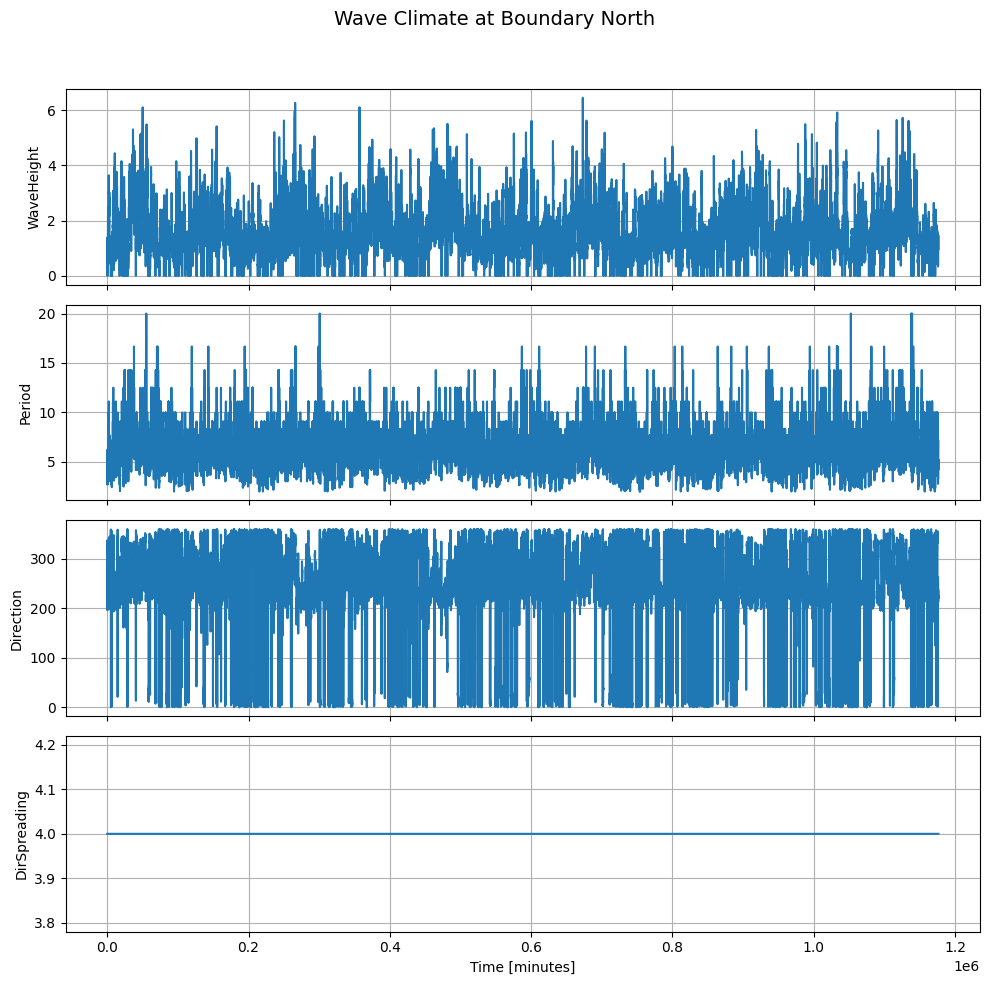

In [4]:
import re
import matplotlib.pyplot as plt
import pandas as pd

def parse_bcw_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    boundaries = {}
    current_boundary = None
    params = []
    data = []
    reading_data = False

    for line in lines:
        if line.strip().startswith("location"):
            if current_boundary and data:
                # Save previous boundary
                df = pd.DataFrame(data, columns=params)
                df['time'] = pd.to_numeric(df['time'], errors='coerce')
                df = df.set_index('time')
                boundaries[current_boundary] = df
                data = []

            # Start new boundary
            current_boundary = re.search(r"'(.*?)'", line).group(1)
            params = []
            reading_data = False

        elif line.strip().startswith("parameter"):
            param_match = re.search(r"parameter\s+'(\w+)'", line)
            if param_match:
                param = param_match.group(1)
                params.append(param)
        
        elif re.match(r'^\d', line.strip()):
            reading_data = True
            values = [float(v) for v in line.strip().split()]
            data.append(values)

    # Final boundary
    if current_boundary and data:
        df = pd.DataFrame(data, columns=params)
        df['time'] = pd.to_numeric(df['time'], errors='coerce')
        df = df.set_index('time')
        boundaries[current_boundary] = df

    return boundaries

def plot_boundary_data(boundaries):
    for boundary, df in boundaries.items():
        fig, axes = plt.subplots(len(df.columns), 1, figsize=(10, 2.5 * len(df.columns)), sharex=True)
        fig.suptitle(f"Wave Climate at {boundary}", fontsize=14)

        if len(df.columns) == 1:
            axes = [axes]

        for i, column in enumerate(df.columns):
            axes[i].plot(df.index, df[column])
            axes[i].set_ylabel(column)
            axes[i].grid(True)

        axes[-1].set_xlabel("Time [minutes]")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# === Usage ===
file_path = r"/p/11207608-coclico/MSc_students/Daniel/Delfland/Final_Runs/zm_fromBart_v0_1/wave/waves_filtered_compr_2011_2022.bcw"  # Replace with the actual path
boundaries = parse_bcw_file(file_path)
plot_boundary_data(boundaries)


In [69]:
print(boundaries.keys())

dict_keys(['Boundary South', 'Boundary West', 'Boundary North'])


In [26]:
# Split Boundary West into two DataFrames
df_west = boundaries['Boundary West']

west_1 = pd.DataFrame({
    'WaveHeight': df_west.iloc[:, 0],
    'Period': df_west.iloc[:, 2],
    'Direction': df_west.iloc[:, 4],
    'DirSpreading': df_west.iloc[:, 6]
}, index=df_west.index)

west_2 = pd.DataFrame({
    'WaveHeight': df_west.iloc[:, 1],
    'Period': df_west.iloc[:, 3],
    'Direction': df_west.iloc[:, 5],
    'DirSpreading': df_west.iloc[:, 7]
}, index=df_west.index)

# Optional: rename for clarity
west_1.name = 'Boundary West 1'
west_2.name = 'Boundary West 2'

# Add to new dictionary
boundaries_split = {
    'Boundary West 1': west_1,
    'Boundary West 2': west_2
}

# Show confirmation
for name in ['Boundary West 1', 'Boundary West 2']:
    print(f"\n{name}:\n", boundaries_split[name].head())



Boundary West 1:
       WaveHeight  Period  Direction  DirSpreading
time                                             
0.0         0.28  4.3478      354.0           4.0
20.0        0.28  4.1667        5.0           4.0
40.0        0.33  4.0000       38.0           4.0
60.0        0.34  3.4483       40.0           4.0
80.0        0.32  3.8462      234.0           4.0

Boundary West 2:
       WaveHeight  Period  Direction  DirSpreading
time                                             
0.0         0.23  3.7037      274.0           4.0
20.0        0.23  3.7037      212.0           4.0
40.0        0.21  3.1250      277.0           4.0
60.0        0.23  4.3478      337.0           4.0
80.0        0.23  4.5455      258.0           4.0


In [27]:
import pandas as pd

# List of boundaries to process
stats_summary = []

for name, df in boundaries_split.items():
    summary = df.agg(['mean', 'max', 'min']).T
    summary.columns = [f'{stat}' for stat in summary.columns]
    summary['Boundary'] = name
    summary['Parameter'] = summary.index
    stats_summary.append(summary)

# Combine into one DataFrame
summary_df = pd.concat(stats_summary)
summary_df = summary_df[['Boundary', 'Parameter', 'mean', 'max', 'min']].reset_index(drop=True)

# Show summary table
print(summary_df.to_string(index=False))



       Boundary    Parameter       mean    max  min
Boundary West 1   WaveHeight   1.539760   5.71  0.0
Boundary West 1       Period   6.073883  20.00  2.0
Boundary West 1    Direction 225.914064 360.00  0.0
Boundary West 1 DirSpreading   4.000000   4.00  4.0
Boundary West 2   WaveHeight   1.606635   6.44  0.0
Boundary West 2       Period   6.439550  20.00  2.0
Boundary West 2    Direction 240.845452 360.00  0.0
Boundary West 2 DirSpreading   4.000000   4.00  4.0


In [209]:
def transform_wave_conditions(boundaries, height_factor=1.0, direction_shift=0.0, mirror_axis=None):
    """
    Applies transformations to wave conditions.
    
    Parameters:
        boundaries: dict of DataFrames with keys like 'Boundary West 1', etc.
        height_factor: multiplier for WaveHeight (e.g. 1.1 = +10%)
        direction_shift: degrees to shift Direction (can be negative)
    
    Returns:
        Updated boundaries dict with transformed West 1 & 2 and replicated South & North.
    """
    transformed = {}

    for key in ['Boundary West 1', 'Boundary West 2']:
        df = boundaries[key].copy()

        if 'WaveHeight' in df.columns:
            df['WaveHeight'] *= height_factor

        if 'Direction' in df.columns:
            # Apply shift and modulo
            df['Direction'] = (df['Direction'] + direction_shift) % 360

            # Apply your custom condition:
            mask = (df['Direction'] > 55) & (df['Direction'] < 180)
            df.loc[mask, 'Direction'] = (df.loc[mask, 'Direction'] + 180) % 360
            if mirror_axis is not None:
                # Mirror the direction around the specified axis
                df['Direction'] = mirror_direction(df['Direction'], mirror_axis)

        transformed[key] = df

    return transformed

def mirror_direction(directions, axis_angle):
    """
    Mirror directions around the given axis angle.

    Parameters:
        directions: pandas Series or array of direction values (degrees)
        axis_angle: float, axis angle in degrees

    Returns:
        mirrored directions modulo 360 degrees
    """
    mirrored = 2 * axis_angle - directions
    mirrored = mirrored % 360
    return mirrored


In [212]:
boundaries_transformed = transform_wave_conditions(boundaries_split, height_factor=1, direction_shift=90)

In [66]:
print(boundaries_transformed.keys())

dict_keys(['Boundary West 1', 'Boundary West 2'])


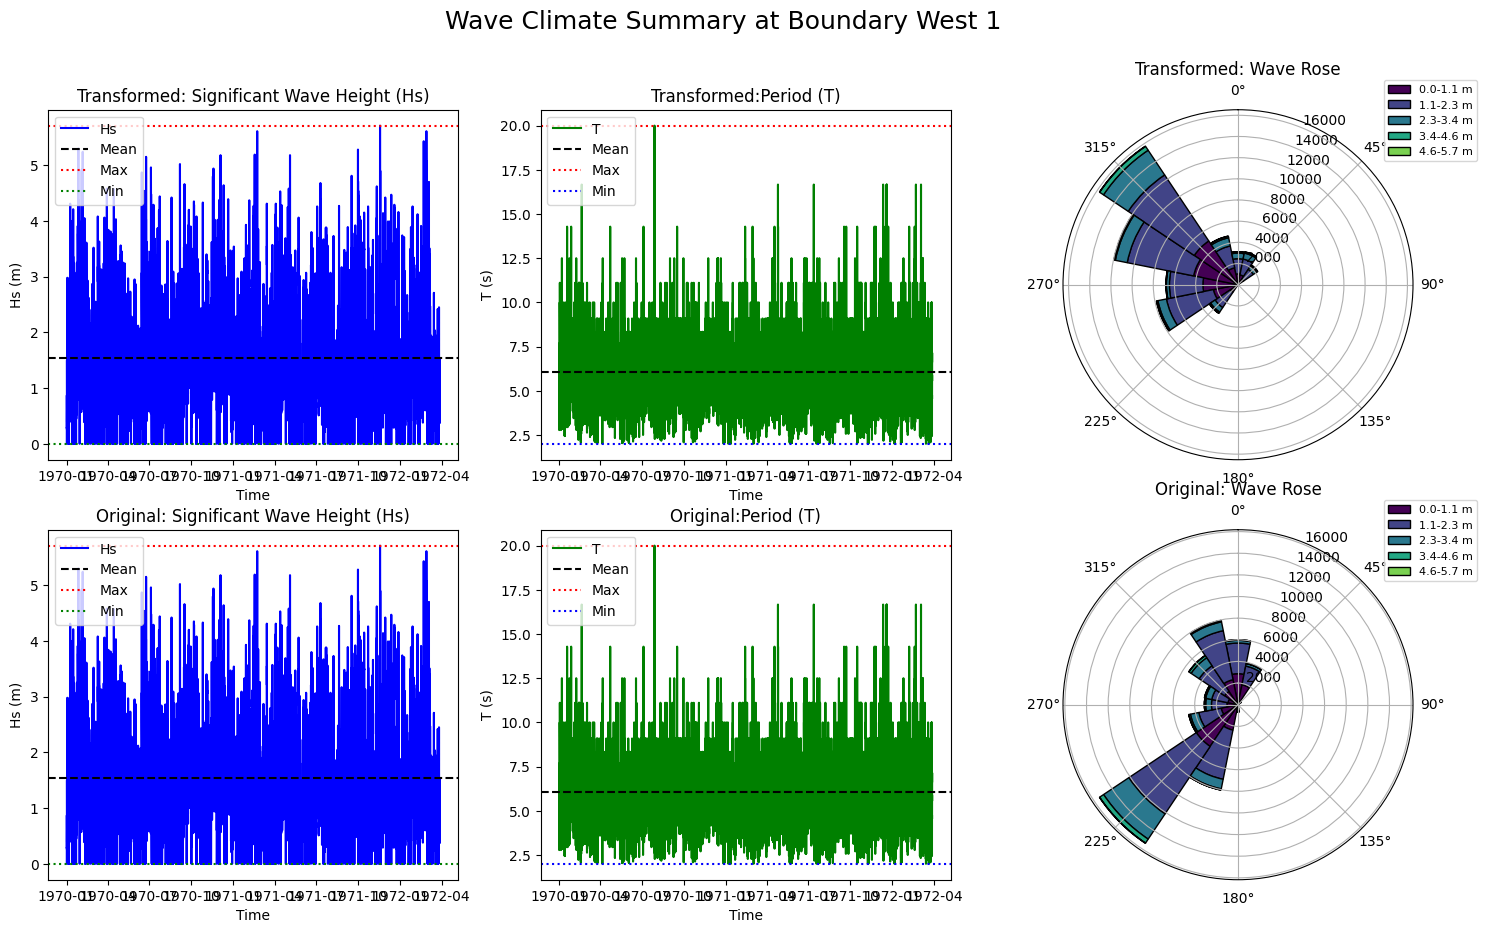

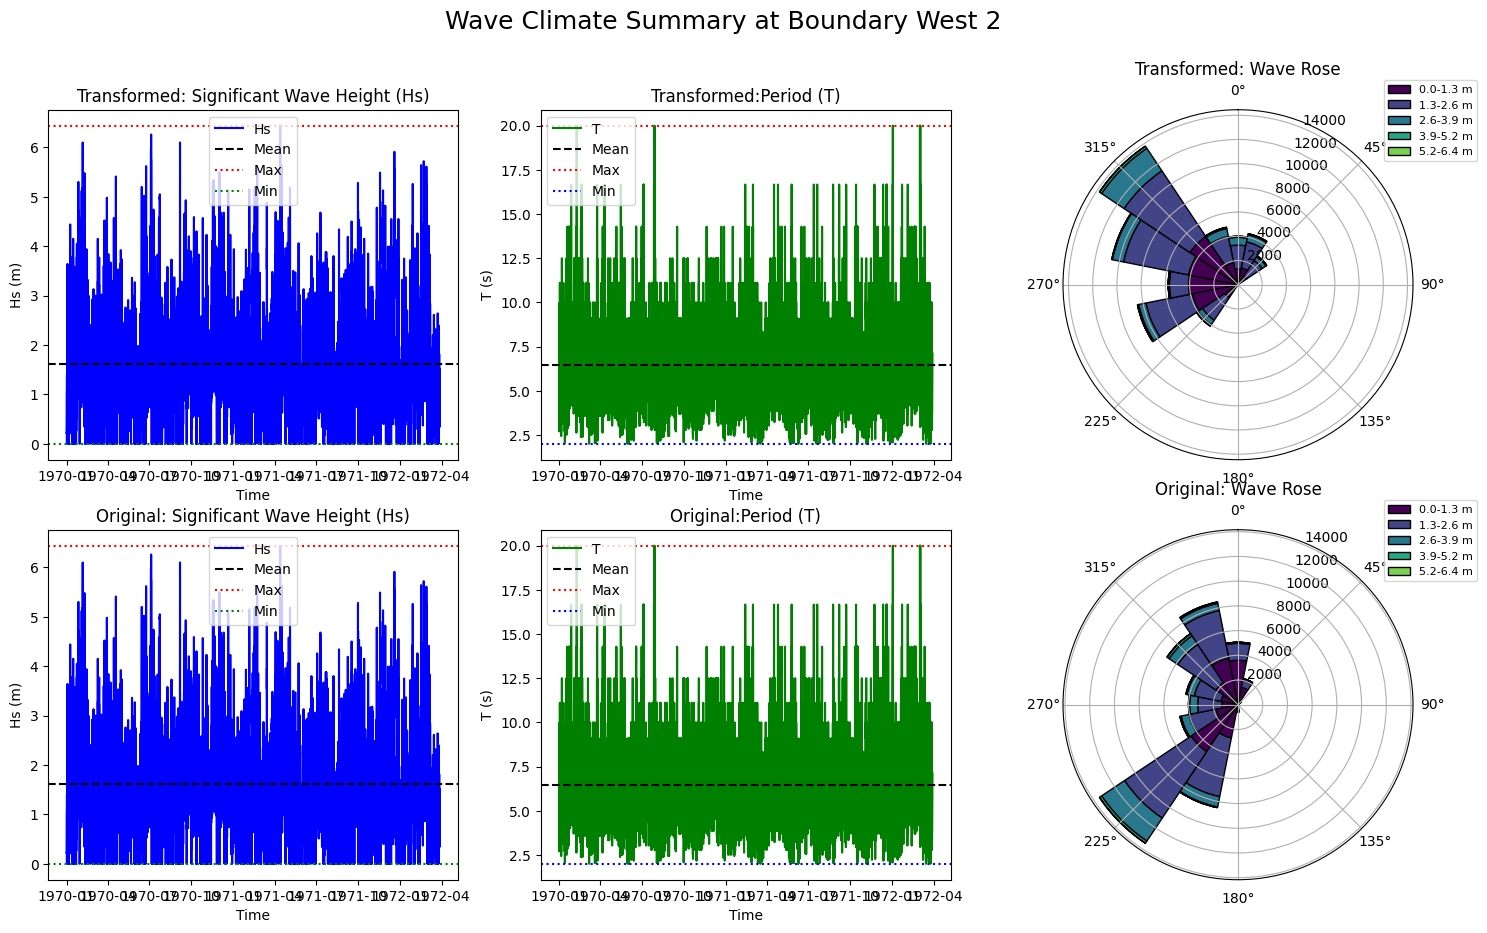

In [213]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm

def plot_wave_summary(boundary_name, transformed_df, original_df):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    def prepare_df(df):
        df = df.copy()
        if 'Datetime' not in df.columns:
            df['Datetime'] = pd.to_datetime(df.index, unit='m')  # adjust unit if needed
        return df

    transformed_df = prepare_df(transformed_df)
    original_df = prepare_df(original_df)

    datasets = [('Transformed', transformed_df, axs[0]), ('Original', original_df, axs[1])]

    for label, df, ax_row in datasets:
        time = df['Datetime']
        Hs = df['WaveHeight']
        Tp = df['Period']
        Dir = df['Direction']

        # Subplot 1: Hs
        ax_row[0].plot(time, Hs, color='blue', label='Hs')
        ax_row[0].axhline(Hs.mean(), color='black', linestyle='--', label='Mean')
        ax_row[0].axhline(Hs.max(), color='red', linestyle=':', label='Max')
        ax_row[0].axhline(Hs.min(), color='green', linestyle=':', label='Min')
        ax_row[0].set_title(f"{label}: Significant Wave Height (Hs)")
        ax_row[0].set_ylabel("Hs (m)")
        ax_row[0].set_xlabel("Time")
        ax_row[0].legend()

        # Subplot 2: Tp
        ax_row[1].plot(time, Tp, color='green', label='T')
        ax_row[1].axhline(Tp.mean(), color='black', linestyle='--', label='Mean')
        ax_row[1].axhline(Tp.max(), color='red', linestyle=':', label='Max')
        ax_row[1].axhline(Tp.min(), color='blue', linestyle=':', label='Min')
        ax_row[1].set_title(f"{label}:Period (T)")
        ax_row[1].set_ylabel("T (s)")
        ax_row[1].set_xlabel("Time")
        ax_row[1].legend()

        # Subplot 3: Wave Rose
        ax_row[2].remove()
        ax_rose = fig.add_subplot(2, 3, (3 if label == 'Transformed' else 6), polar=True)

        theta = np.deg2rad(Dir)
        r = Hs

        n_bins_dir = 16
        n_bins_hs = 5
        dir_bins = np.linspace(0, 2 * np.pi, n_bins_dir + 1)
        hs_bins = np.linspace(0, np.nanmax(Hs), n_bins_hs + 1)

        hist, _, _ = np.histogram2d(theta, Hs, bins=[dir_bins, hs_bins])
        hist = hist.T

        for i in range(n_bins_hs):
            radii = hist[i]
            width = (2 * np.pi) / n_bins_dir
            bottom = np.sum(hist[:i], axis=0)
            bars = ax_rose.bar(dir_bins[:-1], radii, width=width, bottom=bottom,
                               color=cm.viridis(i / n_bins_hs), edgecolor='black',
                               label=f'{hs_bins[i]:.1f}-{hs_bins[i+1]:.1f} m')

        ax_rose.set_theta_zero_location("N")
        ax_rose.set_theta_direction(-1)
        ax_rose.set_title(f"{label}: Wave Rose")
        ax_rose.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=8)

    plt.suptitle(f"Wave Climate Summary at {boundary_name}", fontsize=18)
    plt.show()


for name in boundaries_transformed:
    df_trans = boundaries_transformed[name]
    df_orig = boundaries_split[name]
    plot_wave_summary(name, df_trans, df_orig)

In [115]:
def write_bcw_file_from_transformed(original_file, output_file, boundaries_original, boundaries_transformed):
    """
    original_file: path to the original .bcw file (to preserve headers and order)
    output_file: path to save the new .bcw file
    boundaries_original: dict of DataFrames from original parsing
    boundaries_transformed: dict with keys 'Boundary West 1' and 'Boundary West 2' transformed dataframes
    """

    with open(original_file, 'r') as f:
        lines = f.readlines()

    # We'll write the output lines here
    out_lines = []

    current_boundary = None
    header_lines = []
    data_lines = []
    reading_data = False
    params = []
    col_count = 0

    def write_block(boundary_name, header_lines, df):
        """
        Writes a block for boundary_name using header_lines and dataframe df.
        Respects original formatting: spacing, parameter lines, number formatting.
        """

        out = []
        out.extend(header_lines)

        # Make sure the parameters order matches header_lines for columns
        # Count how many parameters lines in header (needed for spacing)
        param_lines = [line for line in header_lines if line.strip().startswith('parameter')]

        # Columns in df should match param_lines in count; 
        # some parameters repeat, e.g. 'WaveHeight' twice for Boundary West
        # We'll write data rows with columns matching the param_lines count

        # Format numbers in scientific notation with 7 decimals
        # Columns are in the same order as in df.columns
        for time_index, row in df.iterrows():
            line_values = [f"{time_index:.7e}"]
            for col in df.columns:
                val = row[col]
                line_values.append(f"{val:.7e}")

            # Join columns with tab or space (file uses tab or spaces)
            out.append("\t".join(line_values) + "\n")

        return out

    i = 0
    n = len(lines)

    while i < n:
        line = lines[i]
        if line.strip().startswith("location"):
            # If we have previous boundary block, write it out now
            if current_boundary is not None:
                # Write block for previous boundary
                if current_boundary == 'Boundary South':
                    # Replace data with boundaries_transformed['Boundary West 1']
                    df = boundaries_transformed.get('Boundary West 1', boundaries_original[current_boundary])
                    out_lines.extend(write_block(current_boundary, header_lines, df))
                elif current_boundary == 'Boundary North':
                    # Replace data with boundaries_transformed['Boundary West 2']
                    df = boundaries_transformed.get('Boundary West 2', boundaries_original[current_boundary])
                    out_lines.extend(write_block(current_boundary, header_lines, df))
                elif current_boundary == 'Boundary West':
                    # For Boundary West, combine West 1 and West 2 side by side,
                    # careful with column order, replicate original columns, etc.

                    # Get dfs
                    df_w1 = boundaries_transformed.get('Boundary West 1')
                    df_w2 = boundaries_transformed.get('Boundary West 2')

                    if df_w1 is None or df_w2 is None:
                        # Fallback: write original
                        df = boundaries_original[current_boundary]
                        out_lines.extend(write_block(current_boundary, header_lines, df))
                    else:
                        # Combine side by side (horizontally)
                        # Original 'Boundary West' seems to have duplicated columns (WaveHeight, Period, Direction, DirSpreading)
                        # We'll create combined dataframe with columns:
                        # time, WaveHeight1, WaveHeight2, Period1, Period2, Direction1, Direction2, DirSpreading1, DirSpreading2

                        # Make sure time indices match
                        # Let's do outer join on index (time)
                        combined_df = pd.concat([df_w1, df_w2], axis=1, join='outer', keys=['W1', 'W2'])

                        # Flatten columns with MultiIndex keys
                        combined_df.columns = [f"{col}{'1' if key=='W1' else '2'}" for key, col in combined_df.columns]

                        # Make sure columns order matches the original Boundary West params order:
                        # Example original param order (from your file snippet):
                        # 'time', 'WaveHeight', 'WaveHeight', 'Period', 'Period', 'Direction', 'Direction', 'DirSpreading', 'DirSpreading'
                        # We'll map these to W1 and W2 respectively:

                        # Check which params repeat and order accordingly
                        param_order = ['WaveHeight1', 'WaveHeight2', 'Period1', 'Period2', 'Direction1', 'Direction2', 'DirSpreading1', 'DirSpreading2']

                        # Include time index as the first column (index)
                        combined_df = combined_df[param_order]

                        # Write combined block
                        out_lines.extend(write_block(current_boundary, header_lines, combined_df))

                else:
                    # For other boundaries, write original
                    df = boundaries_original[current_boundary]
                    out_lines.extend(write_block(current_boundary, header_lines, df))

                header_lines = []

            # Start new boundary block
            current_boundary = re.search(r"'(.*?)'", line).group(1)
            header_lines = [line]
            i += 1

            # Read ahead the header lines until first data line or blank
            while i < n:
                if re.match(r'^\d', lines[i].strip()):
                    # Start of data lines
                    break
                header_lines.append(lines[i])
                i += 1

            # Continue to next iteration to process data lines inside next loop
            continue

        # For data lines, just skip them here as they are handled in write_block
        i += 1

    # Write last boundary block after file ends
    if current_boundary is not None:
        if current_boundary == 'Boundary South':
            df = boundaries_transformed.get('Boundary West 1', boundaries_original[current_boundary])
            out_lines.extend(write_block(current_boundary, header_lines, df))
        elif current_boundary == 'Boundary North':
            df = boundaries_transformed.get('Boundary West 2', boundaries_original[current_boundary])
            out_lines.extend(write_block(current_boundary, header_lines, df))
        elif current_boundary == 'Boundary West':
            df_w1 = boundaries_transformed.get('Boundary West 1')
            df_w2 = boundaries_transformed.get('Boundary West 2')
            if df_w1 is None or df_w2 is None:
                df = boundaries_original[current_boundary]
                out_lines.extend(write_block(current_boundary, header_lines, df))
            else:
                combined_df = pd.concat([df_w1, df_w2], axis=1, join='outer', keys=['W1', 'W2'])
                combined_df.columns = [f"{col}{'1' if key=='W1' else '2'}" for key, col in combined_df.columns]
                param_order = ['WaveHeight1', 'WaveHeight2', 'Period1', 'Period2', 'Direction1', 'Direction2', 'DirSpreading1', 'DirSpreading2']
                combined_df = combined_df[param_order]
                out_lines.extend(write_block(current_boundary, header_lines, combined_df))
        else:
            df = boundaries_original[current_boundary]
            out_lines.extend(write_block(current_boundary, header_lines, df))

    # Write output to file
    with open(output_file, 'w') as f:
        f.writelines(out_lines)

    print(f"Written transformed data to {output_file}")


In [199]:
write_bcw_file_from_transformed(
    original_file=r"/p/11207608-coclico/MSc_students/Daniel/Delfland/Final_Runs/zm_fromBart_v0_1/wave/waves_filtered_compr_2011_2022.bcw",
    output_file=r"/p/11207608-coclico/MSc_students/Daniel/Delfland/waves/waveNW_N_v5.bcw",
    boundaries_original=boundaries,
    boundaries_transformed=boundaries_transformed
)

Written transformed data to /p/11207608-coclico/MSc_students/Daniel/Delfland/waves/waveNW_N_v5.bcw


/tmp/ipykernel_2162096/578534633.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)


                Hs   Direction    Period
Time (s)                                
0         0.000000  270.000000  0.000000
1         0.488770   15.165527  3.246030
2         0.457995  252.199312  3.253223
3         0.469096  245.298769  3.233148
4         0.829439  248.173794  4.235757


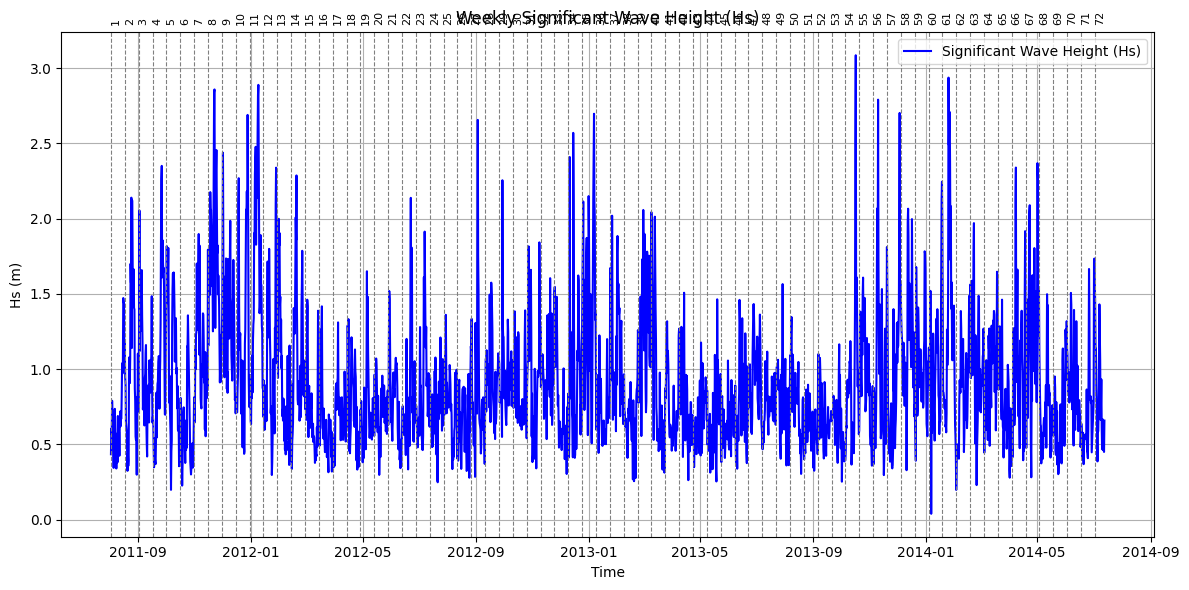

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

#read csv
path = r"/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/data/zm_fromBart_v0_1/weekly/time_series_data.csv"
df = pd.read_csv(path, index_col=0, parse_dates=True)
# Display the first few rows of the DataFrame
print(df.head())

time = 'bi-monthly'
time_dict = {"weekly": 34, "bi-monthly": 72, "monthly": 144}
output_freq = 2  # hours
wave_steps_per_frame = time_dict[time] // output_freq 

initial = pd.to_datetime('2011-08-01 00:00:00')
start = initial + pd.Timedelta(hours=wave_steps_per_frame)
step = pd.Timedelta(hours=10)

#delete the first week or biweek
df = df.iloc[wave_steps_per_frame:]
#delete the last week or biweek
#df = df.iloc[:-wave_steps_per_frame]
# reset index to start at 0
df.reset_index(drop=True, inplace=True)


# change time index to start at 2011-08-01 00:00:00 and step by 10 hours
df.index = pd.date_range(start=start, periods=len(df), freq=step)

#plot time series time vs HS
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Hs'], label='Significant Wave Height (Hs)', color='blue')

# Add vertical lines and index labels
interval_hours = 170 if time == 'weekly' else 360  # weekly = 7 days * 24h, biweekly = 14 * 24h
interval = pd.Timedelta(hours=interval_hours)

for i, t in enumerate(df.index[::interval_hours // 10], start=1):  # //10 since freq=10h
    plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.8)
    plt.text(t, df['Hs'].max() + 0.2, str(i), rotation=90, verticalalignment='bottom', fontsize=8)

plt.title('Weekly Significant Wave Height (Hs)')
plt.xlabel('Time')
plt.ylabel('Hs (m)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
